In [1]:
# System
import pathlib
import glob
import os, os.path, shutil
# Data Exploration
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import pandas as pd
import seaborn as sns
from PIL import Image
# Machine Learning
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
#Deep Learning
import tensorflow as tf
import keras
from keras.utils import plot_model ######
from keras import backend as K ##########
from keras import metrics
from keras.regularizers import l2,l1
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation
from keras.preprocessing.image import img_to_array, ImageDataGenerator, array_to_img, load_img
from keras.metrics import AUC
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
# Something unknown :)
import pydot
from dask import bag,  diagnostics
from mlxtend.plotting import plot_confusion_matrix

In [2]:
train_dir = "D:/Work/Corrosion_Detection/Data_Split/Train"
train_CORROSION_dir = "D:/Work/Corrosion_Detection/Data_Split/Train/CORROSION"
train_NOCORROSION_dir = "D:/Work/Corrosion_Detection/Data_Split/Train/NOCORROSION"

validation_dir = "D:/Work/Corrosion_Detection/Data_Split/Validation"
validation_CORROSION_dir = "D:/Work/Corrosion_Detection/Data_Split/Validation/CORROSION"
validation_NOCORROSION_dir = "D:/Work/Corrosion_Detection/Data_Split/Validation/NOCORROSION"

test_dir = "D:/Work/Corrosion_Detection/Data_Split/Test"
test_CORROSION_dir = "D:/Work/Corrosion_Detection/Data_Split/Test/CORROSION"
test_NOCORROSION_dir = "D:/Work/Corrosion_Detection/Data_Split/Test/NOCORROSION"

In [3]:
def num_files_in_direcotry(path):
    num = len([file for file in os.listdir(path) if file.endswith('.jpg')])
    return num

In [4]:
train_CORROSION_num = num_files_in_direcotry(train_CORROSION_dir)
train_NOCORROSION_num = num_files_in_direcotry(train_NOCORROSION_dir)
train_SUM_num = train_CORROSION_num + train_NOCORROSION_num

print("[Train] Number of CORROSION Images: ", train_CORROSION_num)
print("[Train] Number of NOCORROSION Images: ", train_NOCORROSION_num)
print("[Train] Number of TOTAL Images: ", train_SUM_num)

[Train] Number of CORROSION Images:  1756
[Train] Number of NOCORROSION Images:  1052
[Train] Number of TOTAL Images:  2808


In [5]:
val_CORROSION_num = num_files_in_direcotry(validation_CORROSION_dir)
val_NOCORROSION_num = num_files_in_direcotry(validation_NOCORROSION_dir)
val_SUM_num = val_CORROSION_num + val_NOCORROSION_num

print("[Validation] Number of CORROSION Images: ", val_CORROSION_num)
print("[Validation] Number of NOCORROSION Images: ", val_NOCORROSION_num)
print("[Validation] Number of TOTAL Images: ", val_SUM_num)

[Validation] Number of CORROSION Images:  502
[Validation] Number of NOCORROSION Images:  301
[Validation] Number of TOTAL Images:  803


In [6]:
test_CORROSION_num = num_files_in_direcotry(test_CORROSION_dir)
test_NOCORROSION_num = num_files_in_direcotry(test_NOCORROSION_dir)
test_SUM_num = test_CORROSION_num + test_NOCORROSION_num

print("[Test] Number of CORROSION Images: ", test_CORROSION_num)
print("[Test] Number of NOCORROSION Images: ", test_NOCORROSION_num)
print("[Test] Number of TOTAL Images: ", test_SUM_num)

[Test] Number of CORROSION Images:  250
[Test] Number of NOCORROSION Images:  150
[Test] Number of TOTAL Images:  400


In [7]:
def create_charts(cnn, cnn_model):
    """
    plot1: train & validatoin loss curves
    plot2: train & validatoin accuracy curves
    Plot3: confusion matrix
    Plot4: train & validation ROC curve and AUC score
    Summary Statistics
    
    """
    
    ## Define train & validation loss
    train_loss = cnn_model.history['loss']
    val_loss = cnn_model.history['val_loss']
    
    ## Define train & validation accuracy
    train_auc = cnn_model.history['acc']
    val_auc = cnn_model.history['val_acc']
    
    ## Define y_pred & y_true
    y_true = test_generator.classes
    Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))
    y_pred = (Y_pred > 0.5).T[0]
    y_pred_prob = Y_pred.T[0]
    
    ## PLOT ##
    fig = plt.figure(figsize=(13, 10))
    
    ## PLOT 1: TRAIN VS. VALIDATION LOSS 
    plt.subplot(2,2,1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    ## PLOT 2: TRAIN VS. VALIDATION Accuracy
    plt.subplot(2,2,2)
    plt.title("Training vs. Validation AUC Score")
    plt.plot(train_auc, label='training auc')
    plt.plot(val_auc, label='validation auc')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()
    
    ## PLOT 3: CONFUSION MATRIX
    plt.subplot(2,2,3)
    # Set up the labels for in the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
  
    names = ['True Positives', 'False Negatives', 'False Positives', 'True Negatives']
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ticklabels = ['CORROSION', 'NOCORROSION']

      # Create confusion matrix as heatmap
    sns.set(font_scale = 1.4)
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels )
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Confusion Matrix") #plt.title("Confusion Matrix\n", fontsize=10)
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14) 
    #plt.savefig('cm.png', transparent=True) 
    
    ## PLOT 4: ROC CURVE
    plt.subplot(2,2,4)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label = "Random (AUC = 50%)")
    plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc*100))
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc='best')
    #plt.savefig('roc.png', bbox_inches='tight', pad_inches=1)
    
    ## END PLOTS
    plt.tight_layout()
    
    ## Summary Statistics
    TP, FN, FP, TN = cm.ravel() # cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
    accuracy = (TP + TN) / np.sum(cm) # % positive out of all predicted positives
    precision = TP / (TP+FP) # % positive out of all predicted positives
    recall =  TP / (TP+FN) # % positive out of all supposed to be positives
    specificity = TN / (TN+FP) # % negative out of all supposed to be negatives
    f1 = 2*precision*recall / (precision + recall)
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    print(stats_summary)

In [8]:
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

In [11]:
# Build data generator function

def make_data_generator(
    train_datagen, train_dir, 
    val_datagen, val_dir, 
    test_datagen, test_dir):
    
    datagen_lst = [train_datagen, val_datagen, test_datagen]
    directory_lst = [train_dir, val_dir, test_dir]
    generator_lst = []
    for generator, directory in zip(datagen_lst, directory_lst):
        if directory == train_dir:
            shuffle = True
        else:
            shuffle = False
        g = generator.flow_from_directory(directory = directory,
                                         target_size = (224,224),
                                         batch_size = 32,
                                         color_mode = 'rgb',
                                         class_mode = 'binary',
                                         shuffle = shuffle,
                                         seed = 42)
        generator_lst.append(g)
    
    return generator_lst

In [12]:
# Load the images

train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   shear_range = 0.2,
                                   zoom_range = 0.2, 
                                   horizontal_flip = True,
                                   vertical_flip = True)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator,val_generator, test_generator = make_data_generator(
    train_datagen, train_dir,
    val_datagen, validation_dir,
    test_datagen, test_dir)

Found 2808 images belonging to 2 classes.
Found 803 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [14]:
 # Design the model
    
def build_model_New():
    cnn = Sequential()

    cnn.add(InputLayer(input_shape=(224, 224, 3)))

    cnn.add(Conv2D(64, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.1))
    
    cnn.add(Conv2D(64, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.25))
    
    cnn.add(Conv2D(128, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.25))
    
    cnn.add(Conv2D(128, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.25))
    

    cnn.add(Flatten())
            
    cnn.add(Dense(256, activation='relu'))
    cnn.add(Dropout(0.25))
    cnn.add(Dense(1, activation='sigmoid'))
    
    # Compile
    cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    return cnn

cnn_New = build_model_New()

In [15]:
cnn_model_New = cnn_New.fit_generator(train_generator,
                              epochs = 100,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1,
                              callbacks=[es])

C:\Users\RAJANA~1\AppData\Local\Temp/ipykernel_20340/3726321931.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn_model_New = cnn_New.fit_generator(train_generator,


Epoch 1/100


88/88 [==============================] - 129s 1s/step - loss: 0.4695 - acc: 0.7963 - val_loss: 0.2967 - val_acc: 0.9390
Epoch 2/100
88/88 [==============================] - 118s 1s/step - loss: 0.2042 - acc: 0.9327 - val_loss: 0.1987 - val_acc: 0.9440
Epoch 3/100
88/88 [==============================] - 118s 1s/step - loss: 0.1705 - acc: 0.9455 - val_loss: 0.2088 - val_acc: 0.9390
Epoch 4/100
88/88 [==============================] - 117s 1s/step - loss: 0.1628 - acc: 0.9491 - val_loss: 0.1926 - val_acc: 0.9477
Epoch 5/100
88/88 [==============================] - 116s 1s/step - loss: 0.1792 - acc: 0.9437 - val_loss: 0.2088 - val_acc: 0.9303
Epoch 6/100
88/88 [==============================] - 117s 1s/step - loss: 0.1796 - acc: 0.9416 - val_loss: 0.1788 - val_acc: 0.9477
Epoch 7/100
88/88 [==============================] - 128s 1s/step - loss: 0.1583 - acc: 0.9512 - val_loss: 0.2151 - val_acc: 0.9489
Epoch 8/100
88/88 [==============================] - 122s 1s/step - loss: 

C:\Users\RAJANA~1\AppData\Local\Temp/ipykernel_20340/2413494331.py:21: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))


[Summary Statistics]
Accuracy = 98.75% | Precision = 99.60% | Recall = 98.40% | Specificity = 99.33% | F1 Score = 98.99%


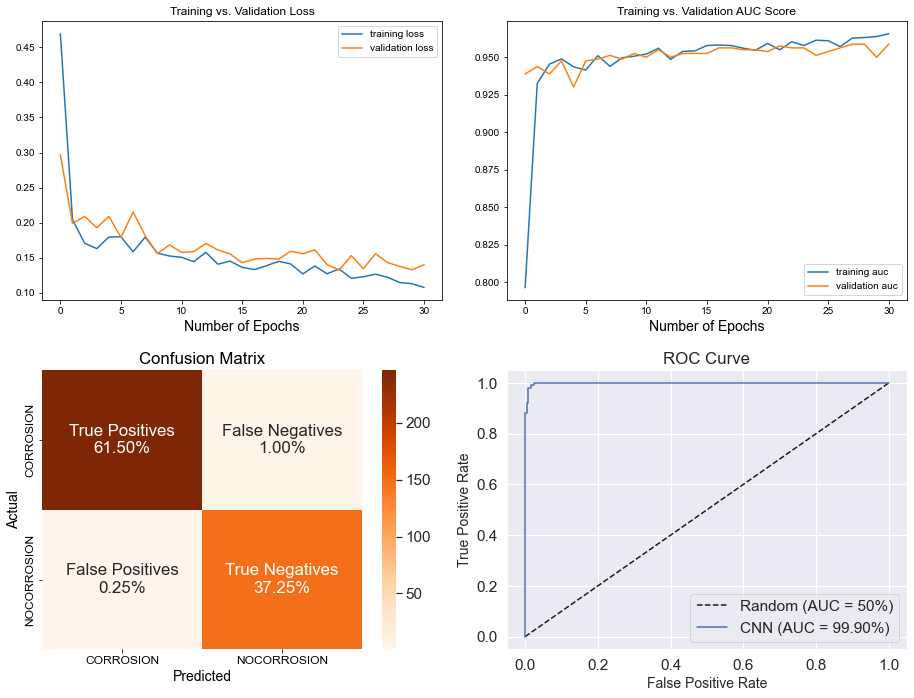

In [16]:
create_charts(cnn_New,cnn_model_New)

C:\Users\RAJANA~1\AppData\Local\Temp/ipykernel_20340/933915836.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = cnn_New.predict_generator(test_generator, steps = len(test_generator))


([<matplotlib.axis.YTick at 0x1a210b59940>,
 [Text(0, 0, 'CORROSION'), Text(0, 1, 'NOCORROSION')])

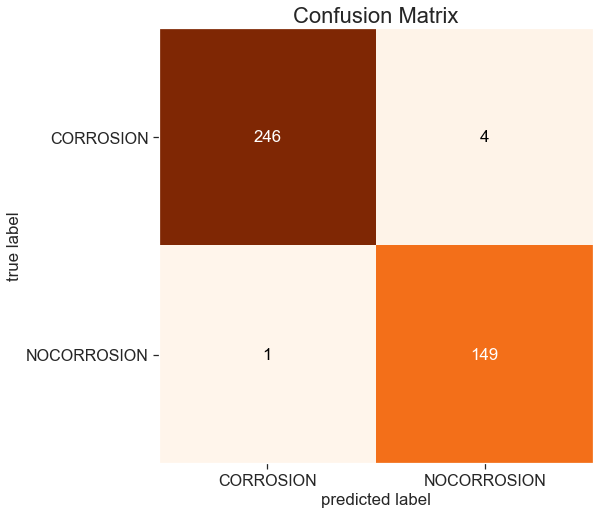

In [17]:
y_true = test_generator.classes
Y_pred = cnn_New.predict_generator(test_generator, steps = len(test_generator))
y_pred = (Y_pred > 0.5).T[0]
y_pred_prob = Y_pred.T[0]
cm = confusion_matrix(y_true,y_pred)
plot_confusion_matrix(cm, figsize = (12,8), hide_ticks = True, cmap = plt.cm.Oranges)
plt.title("Confusion Matrix", fontsize = 22) 
plt.xticks(range(2), ['CORROSION','NOCORROSION'], fontsize = 16)
plt.yticks(range(2), ['CORROSION','NOCORROSION'], fontsize = 16)

13/13 [==============================] - 9s 364ms/step


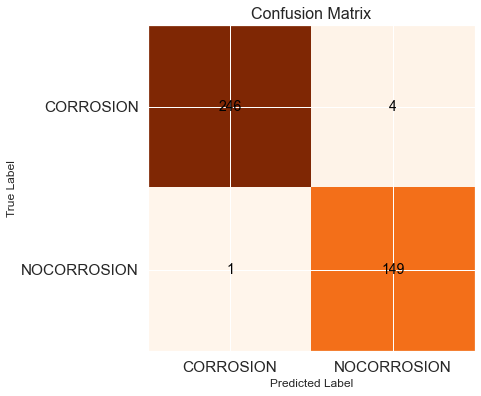


Classification Report:
              precision    recall  f1-score   support

   CORROSION       1.00      0.98      0.99       250
 NOCORROSION       0.97      0.99      0.98       150

    accuracy                           0.99       400
   macro avg       0.98      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400


Class Weights: {0: 0.8, 1: 1.3333333333333333}

Misclassified Corrosion Cases: ['NOCORROSION\\aug_2_Shiny_steel_surface_581.jpg']
Epoch 1/10
88/88 [==============================] - 128s 1s/step - loss: 0.1093 - acc: 0.9651
Epoch 2/10
88/88 [==============================] - 112s 1s/step - loss: 0.1082 - acc: 0.9651
Epoch 3/10
88/88 [==============================] - 112s 1s/step - loss: 0.1108 - acc: 0.9637
Epoch 4/10
88/88 [==============================] - 112s 1s/step - loss: 0.0973 - acc: 0.9665
Epoch 5/10
88/88 [==============================] - 112s 1s/step - loss: 0.1202 - acc: 0.9658
Epoch 6/10
88/88 [==============================

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

# Load test data
y_true = test_generator.classes

# Fix TensorFlow deprecation warning
y_pred_prob = cnn_New.predict(test_generator, steps=len(test_generator))

# Adjust Decision Threshold
threshold = 0.4  # Can be fine-tuned
y_pred = (y_pred_prob >= threshold).astype(int).flatten()

# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap=plt.cm.Oranges)
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks([0, 1], ['CORROSION', 'NOCORROSION'])
plt.yticks([0, 1], ['CORROSION', 'NOCORROSION'])

# Display confusion matrix values
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black', fontsize=14)
plt.show()

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['CORROSION', 'NOCORROSION']))

# Compute Class Weights to Handle Imbalance
class_labels = np.unique(y_true)
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=y_true)
class_weights_dict = {i: class_weights[i] for i in range(len(class_labels))}

print("\nClass Weights:", class_weights_dict)

# Identify False Negatives for Analysis
misclassified_indices = np.where((y_true == 1) & (y_pred == 0))[0]
misclassified_filenames = [test_generator.filenames[i] for i in misclassified_indices]
print("\nMisclassified Corrosion Cases:", misclassified_filenames)

# Retrain the model with class weights
cnn_New.fit(train_generator, epochs=10, class_weight=class_weights_dict)
